<div class="row">
  <div class="column">
    <img src="./img/logo-onera.png" width="200">
  </div>
  <div class="column">
    <img src="./img/logo-ISAE_SUPAERO.png" width="200">
  </div>
</div>

# FAST-OAD-GA Pre-generating Xfoil results

It has been observed that Xfoil would sometimes fail to converge for Reynolds number while it converge for slightly higher/lower Reynolds number. To counter this problem, it was decided to generate the results and do some post-processing to ensure the results are plausible. 

It is worth noting that it is not mandatory to run this notebook before launching FAST-OAD-GA but this would help filter out physically irrelevant results.

In [1]:
import os.path as pth
import openmdao.api as om

import logging
import os
import shutil
import time

from fastoad import api as api_cs25
from fastga.command import api as api_cs23

from fastoad.gui import VariableViewer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define relative path
DATA_FOLDER_PATH = 'data'
WORK_FOLDER_PATH = 'workdir'
RESULT_FOLDER_PATH = 'results'

# Final file names, name doesn't matter as the only used variables are the Reynolds and approach speed 
# defined as input variable later in the code
AIRCRAFT1_FILE = pth.join(WORK_FOLDER_PATH, 'blank.xml')

Failed to import module fastga.models.propulsion.fuel_propulsion.basicIC_engine.unitary_tests.test_openmdao_engine.py
Failed to import module fastga.models.performances.unitary_tests.test_beechcraft_76.py
Failed to import module fastga.models.weight.cg.unitary_tests.test_beechcraft_76.py
Failed to import module fastga.models.geometry.unitary_tests.test_beechcraft_76.py
Failed to import module fastga.models.aerodynamics.unitary_tests.test_beechcraft_76.py
Failed to import module fastga.models.weight.mass_breakdown.unitary_tests.test_beechcraft_76.py
Failed to import module fastga.models.aerodynamics.unitary_tests.test_cirrus_sr22.py
Failed to import module fastga.models.handling_qualities.unitary_tests.test_cirrus_sr22.py
Failed to import module fastga.models.performances.unitary_tests.test_cirrus_sr22.py
Failed to import module fastga.models.weight.mass_breakdown.unitary_tests.test_cirrus_sr22.py
Failed to import module fastga.models.loops.unitary_tests.test_wing_area.py
Failed to impo

Clearing and preparing the work folder by importing the blank .xml file

In [2]:
# Clear work folder
shutil.rmtree(WORK_FOLDER_PATH, ignore_errors=True)
os.mkdir(WORK_FOLDER_PATH)
shutil.copy(pth.join(DATA_FOLDER_PATH, 'blank.xml'), pth.join(WORK_FOLDER_PATH, 'blank.xml'))

'workdir\\blank.xml'

Here we define a few functions that will be used later for the post treatment of the data we will get. The first one allow to delete zeros that may be present in the alpha array while the second one allows to sort a list while keeping the matching data on a second list

In [3]:
def delete_additional_zeros(array_alpha, array_cl):
    """
    Function that delete the additional zeros we had to add to fit the format imposed by OpenMDAO in both the alpha
    and CL array simultaneously

    @param array_alpha: an array with the alpha values and the additional zeros we want to delete
    @param array_cl: the corresponding Cl array
    @return: final_array_alpha an array containing the same alphas of the initial array but with the additional
    zeros deleted
    @return: final_array_CL an array containing the corresponding CL
    """

    non_zero_array = np.where(array_alpha != 0)
    if array_alpha[0] == 0.0:
        valid_data_index = np.insert(non_zero_array, 0, 0)
    else:
        valid_data_index = non_zero_array

    final_array_alpha = array_alpha[valid_data_index]
    final_array_cl = array_cl[valid_data_index]

    return final_array_alpha, final_array_cl

def rearrange_data(array_alpha, array_cl):
    """
    Function that rearrange the data so that the alpha array is sorted and the cl array is rearranged accordingly

    @param array_alpha: an array with the alpha values in potentially the wrong order
    @param array_cl: the corresponding Cl array
    @return: final_array_alpha an array containing the same alphas of the initial array but sorted
    @return: final_array_CL an array containing the corresponding CL in the corresponding position
    """

    sorter = np.zeros((len(array_alpha), 2))
    sorter[:, 0] = array_alpha
    sorter[:, 1] = array_cl
    sorted_alpha = np.sort(sorter, axis=0)
    for alpha in sorted_alpha[:, 0]:
        index_alpha_new = np.where(sorted_alpha[:, 0] == alpha)
        index_alpha_orig = np.where(array_alpha == alpha)
        sorted_alpha[index_alpha_new, 1] = array_cl[index_alpha_orig]

    return sorted_alpha[:, 0], sorted_alpha[:, 1]

We prepare the block analysis that will allows us to run xfoil multiple time at different Reynolds number

In [4]:
from fastga.models.aerodynamics.external.xfoil.xfoil_group import XfoilGroup as Xfoil
from fastga.models.aerodynamics.external.xfoil import resources

var_inputs = ["data:TLAR:v_approach", "data:Xfoil_pre_processing:reynolds"]

airfoil_file_name = "naca23012.af"  

# Declare function
compute_xfoil = api_cs23.generate_block_analysis(
    Xfoil(
        airfoil_file=airfoil_file_name,
        compute_negative_air_angle=True,
    ),
    var_inputs,
    AIRCRAFT1_FILE,
    True,
)

file_path = pth.join(resources.__path__[0], airfoil_file_name.replace('.af', '_20S.csv'))

This is where we define the values of the Reynolds number and approach velocity that are required to run the Xfoil group

In [5]:
reynolds_array_orig = np.linspace(500000, 7000000, num = 25)
print(reynolds_array_orig)

v_approach = 79.0 #In kts

[ 500000.          770833.33333333 1041666.66666667 1312500.
 1583333.33333333 1854166.66666667 2125000.         2395833.33333333
 2666666.66666667 2937500.         3208333.33333333 3479166.66666667
 3750000.         4020833.33333333 4291666.66666667 4562500.
 4833333.33333333 5104166.66666667 5375000.         5645833.33333333
 5916666.66666667 6187500.         6458333.33333333 6729166.66666667
 7000000.        ]


Here we launch the multiples simulations based on the Reynolds number we define in the section above

In [6]:
for reynolds in reynolds_array_orig:
    inputs_dict = {"data:TLAR:v_approach": (v_approach, "kn"),
                   "data:Xfoil_pre_processing:reynolds": (reynolds, None)}
    
    outputs_dict = compute_xfoil(inputs_dict)

2D CL max not found, less than 40% of angle range computed: using default value 1.9


In [7]:
from fastoad.model_base.atmosphere import Atmosphere

sos = Atmosphere(0.0).speed_of_sound
mach_run = round(float(v_approach * 0.5144 / sos), 4)
print(mach_run)

0.1194


Here starts the post treatment of the values we obtained. Since we want to able able to simply add new values for different mach number, we must first find where are the results of this run so we can leave the rest untouched since it was already treated. We also can't simply treat the output of the block analysis since, pending an unconverged run on the negative AoA, the results won't be written in the csv and so errors can occur.

<ipython-input-8-0f45606202b1>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mach_array = values[0].astype(np.float)
<ipython-input-8-0f45606202b1>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  reynolds_array_orig = values[1].astype(np.float)[index_run_orig]
<ipython-input-8-0f45606202b1>:14: DeprecationWarning: `np.float` is a dep

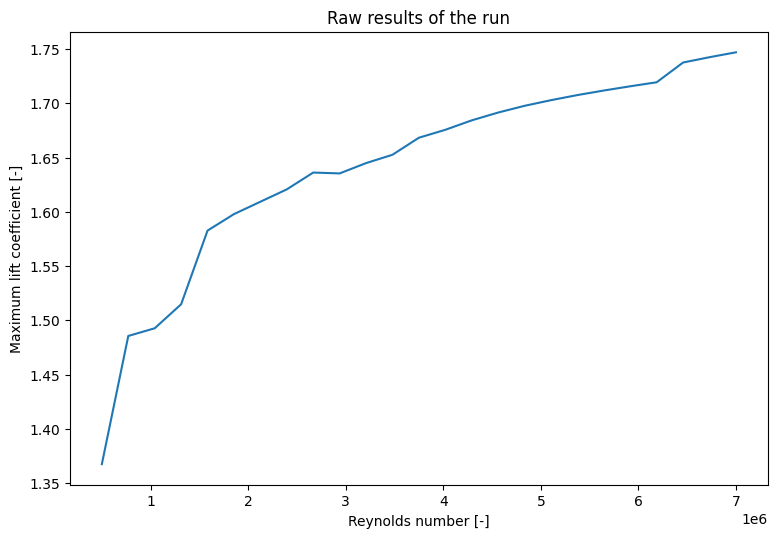

In [8]:
# First, we open the .csv file containing the results of all the run
data_saved = pd.read_csv(file_path)
values = data_saved.to_numpy()[:, 1:len(data_saved.to_numpy()[0])]

# We then identifies to which index correspond to the current run, this is done by searching the appropriate 
# Mach number
mach_array = values[0].astype(np.float)
index_run_orig = np.where(mach_array == mach_run)[0]
# print(index_run_orig)

# Since we have the index corresponding to the current run, we can extract the results and prepare them for 
# post-treatment.
reynolds_array_orig = values[1].astype(np.float)[index_run_orig]
cl_max_array_orig = values[2].astype(np.float)[index_run_orig]
# print(reynolds_array_orig)
# print(cl_max_array_orig)
# plt.plot(reynolds_array_orig, cl_max_array_orig)

# At this point we have all the results of the current run, but nothing assures us that they are in the 
# right order for us to check the valdity of the results.
reynolds_array, cl_max_array = rearrange_data(reynolds_array_orig, cl_max_array_orig)
_, index_run = rearrange_data(reynolds_array_orig, index_run_orig)
index_run = index_run.astype(np.int)
plt.figure(2, figsize=(9,6), dpi= 100)
plt.plot(reynolds_array, cl_max_array)
plt.xlabel("Reynolds number [-]")
plt.ylabel("Maximum lift coefficient [-]")
plt.title("Raw results of the run")
plt.show()
# print(reynolds_array)
# print(cl_max_array)
# print(index_run)

# With this we are assured that the reynolds number are sorted so we can check the validity of the results 
# and we also kept track of which reynolds corresponds to which index in the original values array so we can 
# drop them later

Now comes the treatment of the data,, we are going to make the assumption that the maximum lift coefficient grows with the Reynolds number. Based on this we need to check that for every Reynolds, the maximum lift coefficient is greater than for **all** the previous Reynolds number

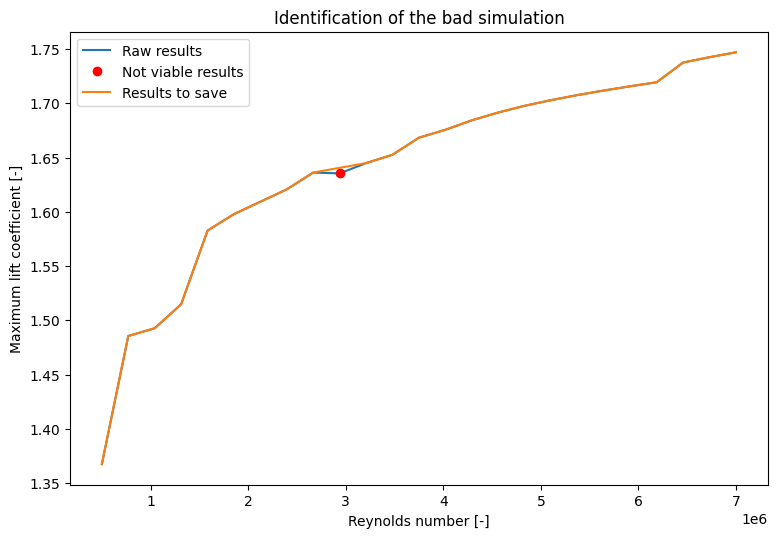

In [9]:
bad_cl_list = []
bad_cl_reynolds_list = []
not_viable_list = []

viable_cl_list = []
viable_cl_reynolds_list = []
viable_list = []

for reynolds in reynolds_array:
    # Since the Reynolds number are sorted we can simply do the following to indetify the "bad" results.
    # We miust recall however that this index doesn't correspond to the index in the full file hence the 
    # the list that stocks the bad index
    i = int(np.where(reynolds_array == reynolds)[0])
    not_viable = np.any(cl_max_array[i]<=cl_max_array[:i])
    if not_viable:
        bad_cl_list.append(cl_max_array[i])
        bad_cl_reynolds_list.append(reynolds_array[i])
        not_viable_list.append(index_run[i])
    else:
        viable_cl_list.append(cl_max_array[i])
        viable_cl_reynolds_list.append(reynolds_array[i])
        viable_list.append(index_run[i])

# We can now plot the Reynolds number that we will delete from the list ...
plt.figure(2, figsize=(9,6), dpi= 100)
plt.plot(reynolds_array, cl_max_array, label="Raw results")
plt.plot(bad_cl_reynolds_list, bad_cl_list, marker='o',color='r',linestyle='', label="Not viable results")

bad_cl_array = np.array(bad_cl_list)
bad_cl_reynolds_array = np.array(bad_cl_reynolds_list)

# print(viable_list)
# print(not_viable_list)
# print('\n Bad Reynolds')
# print(bad_cl_reynolds_array)

# And what will remain in the final file
viable_reynolds_array = np.array(viable_cl_reynolds_list)
viable_cl_max_array = np.array(viable_cl_list)

plt.plot(viable_reynolds_array, viable_cl_max_array, label="Results to save")
plt.xlabel("Reynolds number [-]")
plt.ylabel("Maximum lift coefficient [-]")
plt.title("Identification of the bad simulation")
plt.legend()
plt.show()

In this next part of the code, we will delete the bad Reynolds number starting by the highest one. This is done so that we don't have to modify the index that were used to spot bad simulations. Indeed if we started from the lowest reynolds, we would have had to reduce those index by one each time we deleted a colum

In [10]:
not_viable_list.reverse()
print(not_viable_list)
for i in not_viable_list:
    values = np.delete(values, i, axis=1)

[8]


We do a final check of the data we are going to save before writing it in the result file

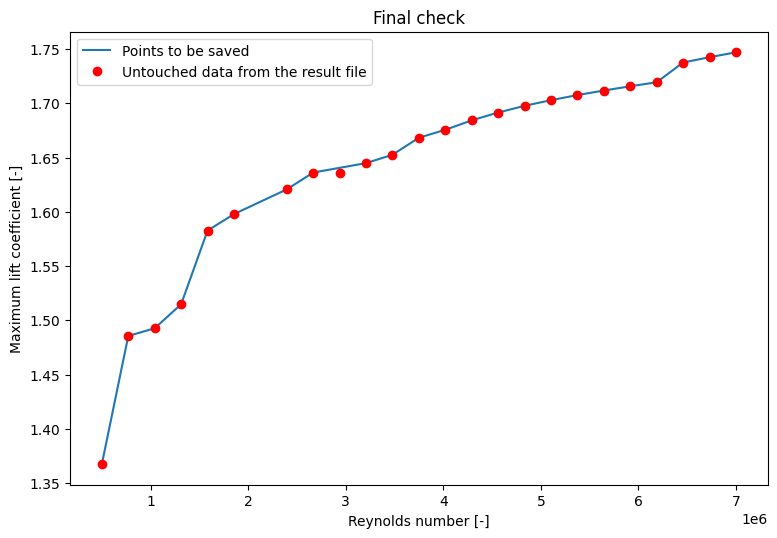

In [11]:
# Final check, we plot the processed data and the raw data to ensure that we did not delete 
# any point we didn't want to delete
plt.figure(3, figsize=(9,6), dpi= 100)
plt.plot(viable_cl_reynolds_list, viable_cl_list, label="Points to be saved")

data_saved = pd.read_csv(file_path)
values_untouched = data_saved.to_numpy()[:, 1:len(data_saved.to_numpy()[0])]

reynolds_array_untouched = np.array(values_untouched[1]).astype(float)[index_run_orig]
cl_max_array_untouched = np.array(values_untouched[2]).astype(float)[index_run_orig]
plt.plot(reynolds_array_untouched, cl_max_array_untouched, marker='o',color='r',linestyle='', label="Untouched data from the result file")
plt.xlabel("Reynolds number [-]")
plt.ylabel("Maximum lift coefficient [-]")
plt.title("Final check")
plt.legend()
plt.show()

Here we save the final results in the resources files of the fastga library in site-package and we also put a copy of it in the results folder that we created earlier so that it can easily be found to be copied anywhere we might need it.

In [12]:
labels = ["mach", "reynolds", "cl_max_2d", "cl_min_2d", "alpha", "cl", "cd", "cdp", "cm"]
cleansed_pd = pd.DataFrame(data=values, index=labels)

result_file_path = pth.join(RESULT_FOLDER_PATH, airfoil_file_name.replace('.af', '_20S_cleansed.csv'))

if os.path.exists(file_path):
    os.remove(file_path)
    
cleansed_pd.to_csv(file_path)
if os.path.exists(result_file_path):
    os.remove(result_file_path)
    
shutil.copy(file_path, result_file_path)

'results\\naca23012_20S_cleansed.csv'